# CAM Zonal Plots

Through communications with Andrew Gettelman, the order of importance for evaluating the tau bin microphysics is: \
High: Liquid Water Path (LWP), Longwave Cloud Forcing (LWCF), Shortwave Cloud Forcing (SWCF) \
Medium: PDF of precipitation intensity (PRECT, total precip; PRECL, precip just from microphysics) \
Low: None

In [11]:
# Import packages
import numpy as np
import xarray as xr
import esmlab
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
import matplotlib
import cartopy.crs as ccrs
import cartopy

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/glade/derecho/scratch/wchuang/tmp/ipykernel_44462/399139686.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [12]:
def open_cesm_dataset(files):
    if isinstance(files,list) and (len(files)==1):
        # If given a list of files but the list contains only 1 element,
        # Use open_dataset to read it in
        ds = xr.open_dataset(files[0], decode_times=False)
    elif isinstance(files,list):
        # If given a list of files with multiple files, use open_mfdataset
        ds = xr.open_mfdataset(files, decode_times=False, combine='by_coords')
    else:
        # If just give a filename string, then open dataset
        ds = xr.open_dataset(files, decode_times=False)
    assert 'time_bnds' in ds  # require time_bnds to derive average time
    bnd_dims = ds['time_bnds'].dims
#    print(f"The time bounds dimension is {bnd_dims[1]}")
    time_correct = ds['time_bnds'].mean(dim=bnd_dims[1])
    time_correct.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time":time_correct})
    ds = xr.decode_cf(ds)
    return ds

In [13]:
pwd='/glade/u/home/wchuang/mlmicrophysics/notebooks/figs/'

# Paths and Simulations
paths=[
       '/glade/derecho/scratch/wchuang/archive/',
       '/glade/derecho/scratch/andrew/archive/',
       # '/glade/derecho/scratch/wchuang/archive/',
       '/glade/derecho/scratch/wchuang/archive/',
       # '/glade/derecho/scratch/wchuang/archive/',
       # '/glade/derecho/scratch/wchuang/archive/'
     ]

prefix=''
# '/glade/derecho/scratch/wchuang/archive/',
# 'cam_ml_emulatedREV4_tst_diag_20240214_replay',
# 'Current TAU',
cases=['run12_kk2000_12month',
       'cam_ml_tauREV4_train',
       # 'run12_3nn_add_CLD_lev_FREQR_12month',
       'run12_1nn_optimized_12month',
       # 'run12_3nn_add_CLD_lev_FREQR_nr_12month',
       # 'run12_3nn_add_CLD_lev_FREQR_12month_proper',
      ]

casetext = [
           'Bulk Microphysics',
           'TAU Bin Microphysics',
           # 'Emulated TAU 3 NN 12 month CLD lev FREQR',
           'TAU Emulation Microphysics',
           # 'Emulated TAU 3 NN 12 month nr',
           # 'Emulated TAU 3 NN 12 month',
           ]

nold=10

case_len=len(cases)  
sep=['/atm/hist/']*case_len

In [14]:
nd=60
dy=np.arange(nd)

In [15]:
# Variable Names
var_names=['TGCLDLWP',
      'TGCLDIWP',
      'CLDTOT',
      'PRECL',
      'SWCF',
      'LWCF',
      # 'ACTNL',
      # 'ACTNI',
      # 'FSNT',
      # 'FSNS',
      # 'FSNTC',
      # 'TOT_CLD_VISTAU',
     ]
var_units=[r'g m$^{-2}$'   ,
      r'g m$^{-2}$'   ,
      'Fraction',
      r'mm d$^{-1}$',
      r'Wm$^{-2}$',
      r'Wm$^{-2}$',
      # r'# cm$^{-3}$',
      # r'# L$^{-1}$',
      # r'Wm$^{-2}$',
      # r'Wm$^{-2}$',
      # r'Wm$^{-2}$',
      # 'Unitless',
     ]
vscl=[1000.        ,
      1000.        ,
      1         ,
      86400000.    ,
      1.     ,
      1,
      # 1.e-6,
      # 1.e-3,
      # 1, 
      # 1,
      # 1,
      # 1,
     ]
varf=[''   ,
      ''   ,
      ''   ,
      '',
      '',
      '',
      # 'FCTL'  ,
      # 'FCTI'  ,
      # '',
      # '',
      # '',
      # '',
     ]
vartx=['Liquid Water Path (LWP)'    ,
       'Ice Water Path (IWP)',    
       'Cloud Fraction',
       'Large Scale Precipitation',
       'SW CRE',
       'Longwave Cloud Radiative Effect',
       # 'Cloud Top Liquid Num', 
       # 'Cloud Top Ice Num',
       # 'RESTOM',
       # 'RESSURF',
       # 'Clr Sky SW',
       # 'Cloud Optical Depth',
      ]
varnout=var_names.copy()
#CERES lwp could be cldwatrad_total_daily or lwp_total_daily
varcdy=['lwp_total_daily',
        'iwp_total_daily', 
        'cldarea_total_daily',
        '',
        '',
        'toa_sw_all_daily',
        'cldtau_total_daily',
        'toa_sw_clr_daily',
        'toa_lw_clr_daily',
       ]
var_name_len=len(var_names)

In [16]:
#Make big arrays to hold regional averages
coordinates = {'runs':casetext, 'variables':var_names}
#Regional or global
mavg = xr.DataArray(np.zeros((case_len, var_name_len)), dims=('runs','variables'), coords=coordinates)

#Make big arrays to hold zonal averages 
temp_in = paths[0]+prefix+cases[0]+sep[0]+cases[0]+'.cam.h0.2005-01.nc'
print(temp_in)
temp_data_in = xr.open_dataset(temp_in)
coords2 = {'runs':casetext, 'variables':varnout, 'lat':temp_data_in.lat}
coords3 = {'runs':casetext, 'variables':varnout, 'lat':temp_data_in.lat, 'lon':temp_data_in.lon}
lat_len = len(temp_data_in.lat)
lon_len = len(temp_data_in.lon)

#Annual Zonal mean
azm = xr.DataArray(np.zeros((case_len, var_name_len, lat_len)), dims=('runs','variables','lat'), coords=coords2)
astd = xr.DataArray(np.zeros((case_len, var_name_len, lat_len)), dims=('runs','variables','lat'), coords=coords2)

#Annual Mean
amb = xr.DataArray(np.zeros((case_len, var_name_len, lat_len, lon_len)), dims=('runs','variables','lat','lon'), coords=coords3)

/glade/derecho/scratch/wchuang/archive/run12_kk2000_12month/atm/hist/run12_kk2000_12month.cam.h0.2005-01.nc


In [17]:
# Select region
ylat = (-90,-90)
xlon = (0,360)

In [18]:
subset = '*.h0.*' # All time

In [19]:
# Monthly Loop
# Loop for cases

Lv = 2.501e6
Lf = 3.337e5

for r in range(case_len):
    if r==nold:
        minfiles = ipthc+prefix+cases[r]+sep[r]+subset
    else:
        minfiles = paths[r]+prefix+cases[r]+sep[r]+subset
    print(cases[r])
    ms1 = xr.open_mfdataset(minfiles,combine='by_coords')
#loop for variables
    for v in range(var_name_len):
#average over region Selected region (lat and lon)
        if (len(varf[v]) > 0):
#zonal mean...
            af=ms1[varf[v]].mean(dim=['time'])
            am=ms1[var_names[v]].mean(dim=['time'])/af
            del af  #,var,varv,freq
# FOR AREL and AWNC only (pick a level)
#            var=varv.isel(lev=24)
        else:
#            var=ms1[var_names[v]].sel(lon=slice(xlon[0],xlon[1]),lat=slice(ylat[0],ylat[1]))
            am=ms1[var_names[v]].mean(dim=['time'])
            #vertical average
            if (var_names[v]=='PRECL'):
                var=ms1[var_names[v]]+ms1['PRECC']
                am=var.mean(dim=('time'))
                del var
            if (var_names[v]=='FSNT'):
                var=ms1[var_names[v]]-ms1['FLNT']
                am=var.mean(dim=('time'))
                del var
            if (var_names[v]=='FSNS'):
#                lhflx=Lv*ms1['QFLX']
                lhflx=(Lv+Lf)*ms1['QFLX']-Lf*1.e3*(ms1['PRECC']+ms1['PRECL']-ms1['PRECSC']-ms1['PRECSL'])
                var=ms1[var_names[v]]-ms1['FLNS']-ms1['SHFLX']-lhflx
                am=var.mean(dim=('time'))
                del lhflx,var
            if (var_names[v]=='TOT_CLD_VISTAU' or var_names[v]=='AODVIS'):
                corr=ms1[var_names[v]].where(ms1[var_names[v]] < 1000.)                           
                if (var_names[v]=='TOT_CLD_VISTAU'):
                    var=corr.sum(dim=('lev'))
                    am=var.mean(dim=('time'))
                    del var
                else:
                    am=corr.mean(dim=('time'))
                del corr
            if (var_names[v]=='FREQR'):
                am=ms1[var_names[v]].mean(dim=['lev','time'])
            if(var_names[v]=='T'):
                var=var.sel(lev=850.,method="nearest")
                am=var.mean(dim=('time'))
                del var
#        print(var_names[v])
#        mavg[r,v]=var.mean()

        if r==nold:
            tmp=am.copy()
            del am
            am=tmp.interp(lat=amb.lat, lon=amb.lon)
            del tmp

        azm[r,v,:]=am.mean(dim=['lon'])
        amb[r,v,:,:]=am
        del am 
        
        
#NOTE: to add standard deviations, will want to rebuild this loop...

run12_kk2000_12month
cam_ml_tauREV4_train
run12_1nn_optimized_12month


Read in observation data from Greg Elssaeser

In [20]:
obs_path = "/glade/work/wchuang/observations/satellite_climatologies_360nlon180nlat_Aug2024.nc"
data = xr.open_mfdataset(obs_path)

In [21]:
data

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 180, lev: 21)
Coordinates:
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat            (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev            (lev) float32 1e+03 925.0 850.0 700.0 ... 7.0 2.0 1.0 0.4
Data variables: (12/17)
    swabs_toa      (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    swcrf_toa      (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    olr            (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lwcrf_toa      (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    pwv            (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    qv             (lev, lat, lon) float32 dask.array<chunksize=(21, 180, 360), meta=np.ndarray>
    ...             ...
    clwp           (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    clt            (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    clt_isccp      (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    clh_isccp      (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    cdnc_cloudtop  (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    vsfc           (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    Title:               Obs4MIPS, CERES-EBAF and NASA MEaSUREs serve as orig...
    Institution:         Goddard Institute for Space Studies (GISS), NASA/Col...
    Source:              Global climatologies assembled by Greg Elsaesser (GI...
    File_Creation_Date:  15 Aug 2024
    Contact:             Greg Elsaesser: gregory.elsaesser@columbia.edu
    Conventions:         CF-1.6

In [22]:
clwp_zonal_mean = data["clwp"]
clwp_zonal_mean

<xarray.DataArray 'clwp' (lat: 180, lon: 360)>
dask.array<open_dataset-clwp, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:  Cloud-only Liquid Water Path from MAC-LWP product filtered fo...
    units:      kg/m2

Read CERES Data (from zonal mean files)

In [23]:
cpth = '/glade/work/andrew/ceres/'
cfile = 'CERES_EBAF_Ed4.1_Subset_200101-201812.nc'
cfile2 = 'CERES_SYN1deg-Month_Terra-Aqua-MODIS_Ed4.1_Subset_200101-201812.nc'

cdat = xr.open_mfdataset(cpth+cfile,combine='by_coords')
cdat2 = xr.open_mfdataset(cpth+cfile2,combine='by_coords')

#Pull out variables
#ctau=cdat['cldtau_total_day_mon']

#Pull variables and Average over time
cswcfzm=cdat['ztoa_cre_sw_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat['ztoa_cre_sw_mon'].groupby("time.month").mean("time")
anom = cdat['ztoa_cre_sw_mon'].groupby("time.month") - climo
cswcfstd=anom.std(dim=['time'])
del climo,anom

clwcfzm=cdat['ztoa_cre_lw_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat['ztoa_cre_lw_mon'].groupby("time.month").mean("time")
anom = cdat['ztoa_cre_lw_mon'].groupby("time.month") - climo
clwcfstd=anom.std(dim=['time'])
del climo,anom

cctotzm=cdat['zcldarea_total_daynight_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat['zcldarea_total_daynight_mon'].groupby("time.month").mean("time")
anom = cdat['zcldarea_total_daynight_mon'].groupby("time.month") - climo
cctotstd=anom.std(dim=['time'])
del climo,anom

ctauzm=cdat['zcldtau_total_day_mon'].mean(dim=['time'])

climo = cdat['zcldtau_total_day_mon'].groupby("time.month").mean("time")
anom = cdat['zcldtau_total_day_mon'].groupby("time.month") - climo
ctaustd=anom.std(dim=['time'])
del climo,anom

cfsntzm=cdat['ztoa_sw_all_mon'].mean(dim=['time'])

cfsntczm=cdat['ztoa_sw_clr_c_mon'].mean(dim=['time'])

/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


In [24]:
cctauzm=cdat2['zcldtau_lin_total_mon'].mean(dim=['time'])

#Standard deviation of monthly anomalies....
climo = cdat2['zcldtau_lin_total_mon'].groupby("time.month").mean("time")
anom = cdat2['zcldtau_lin_total_mon'].groupby("time.month") - climo
cctaustd=anom.std(dim=['time'])
del climo,anom

cclwpzm=cdat2['zlwp_total_mon'].mean(dim=['time'])/1000.

#Standard deviation of monthly anomalies....
climo = cdat2['zlwp_total_mon'].groupby("time.month").mean("time")
anom = cdat2['zlwp_total_mon'].groupby("time.month") - climo
cclwpstd=anom.std(dim=['time'])/1000.
del climo,anom

cciwpzm=cdat2['ziwp_total_mon'].mean(dim=['time'])/1000.
#Standard deviation of monthly anomalies....
climo = cdat2['ziwp_total_mon'].groupby("time.month").mean("time")
anom = cdat2['ziwp_total_mon'].groupby("time.month") - climo
cciwpstd=anom.std(dim=['time'])/1000.
del climo,anom

/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/glade/u/home/wchuang/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


/glade/derecho/scratch/wchuang/tmp/ipykernel_44462/2542601858.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  axs[v].plot(cswcfzm.lat,tmp,linestyles[0], label='EBAF4.1',color='purple',linestyle=':')
/glade/derecho/scratch/wchuang/tmp/ipykernel_44462/2542601858.py:55: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  axs[v].plot(clwp_zonal_mean.lat,tmp,linestyles[0], label='Greg',color='red',linestyle=':')
/glade/derecho/scratch/wchuang/tmp/ipykernel_44462/2542601858.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  axs[v].plot(cswcfzm.lat,tmp,linestyles[0], label='EBAF4.1',color='purple',linestyle=':')
/glade/d

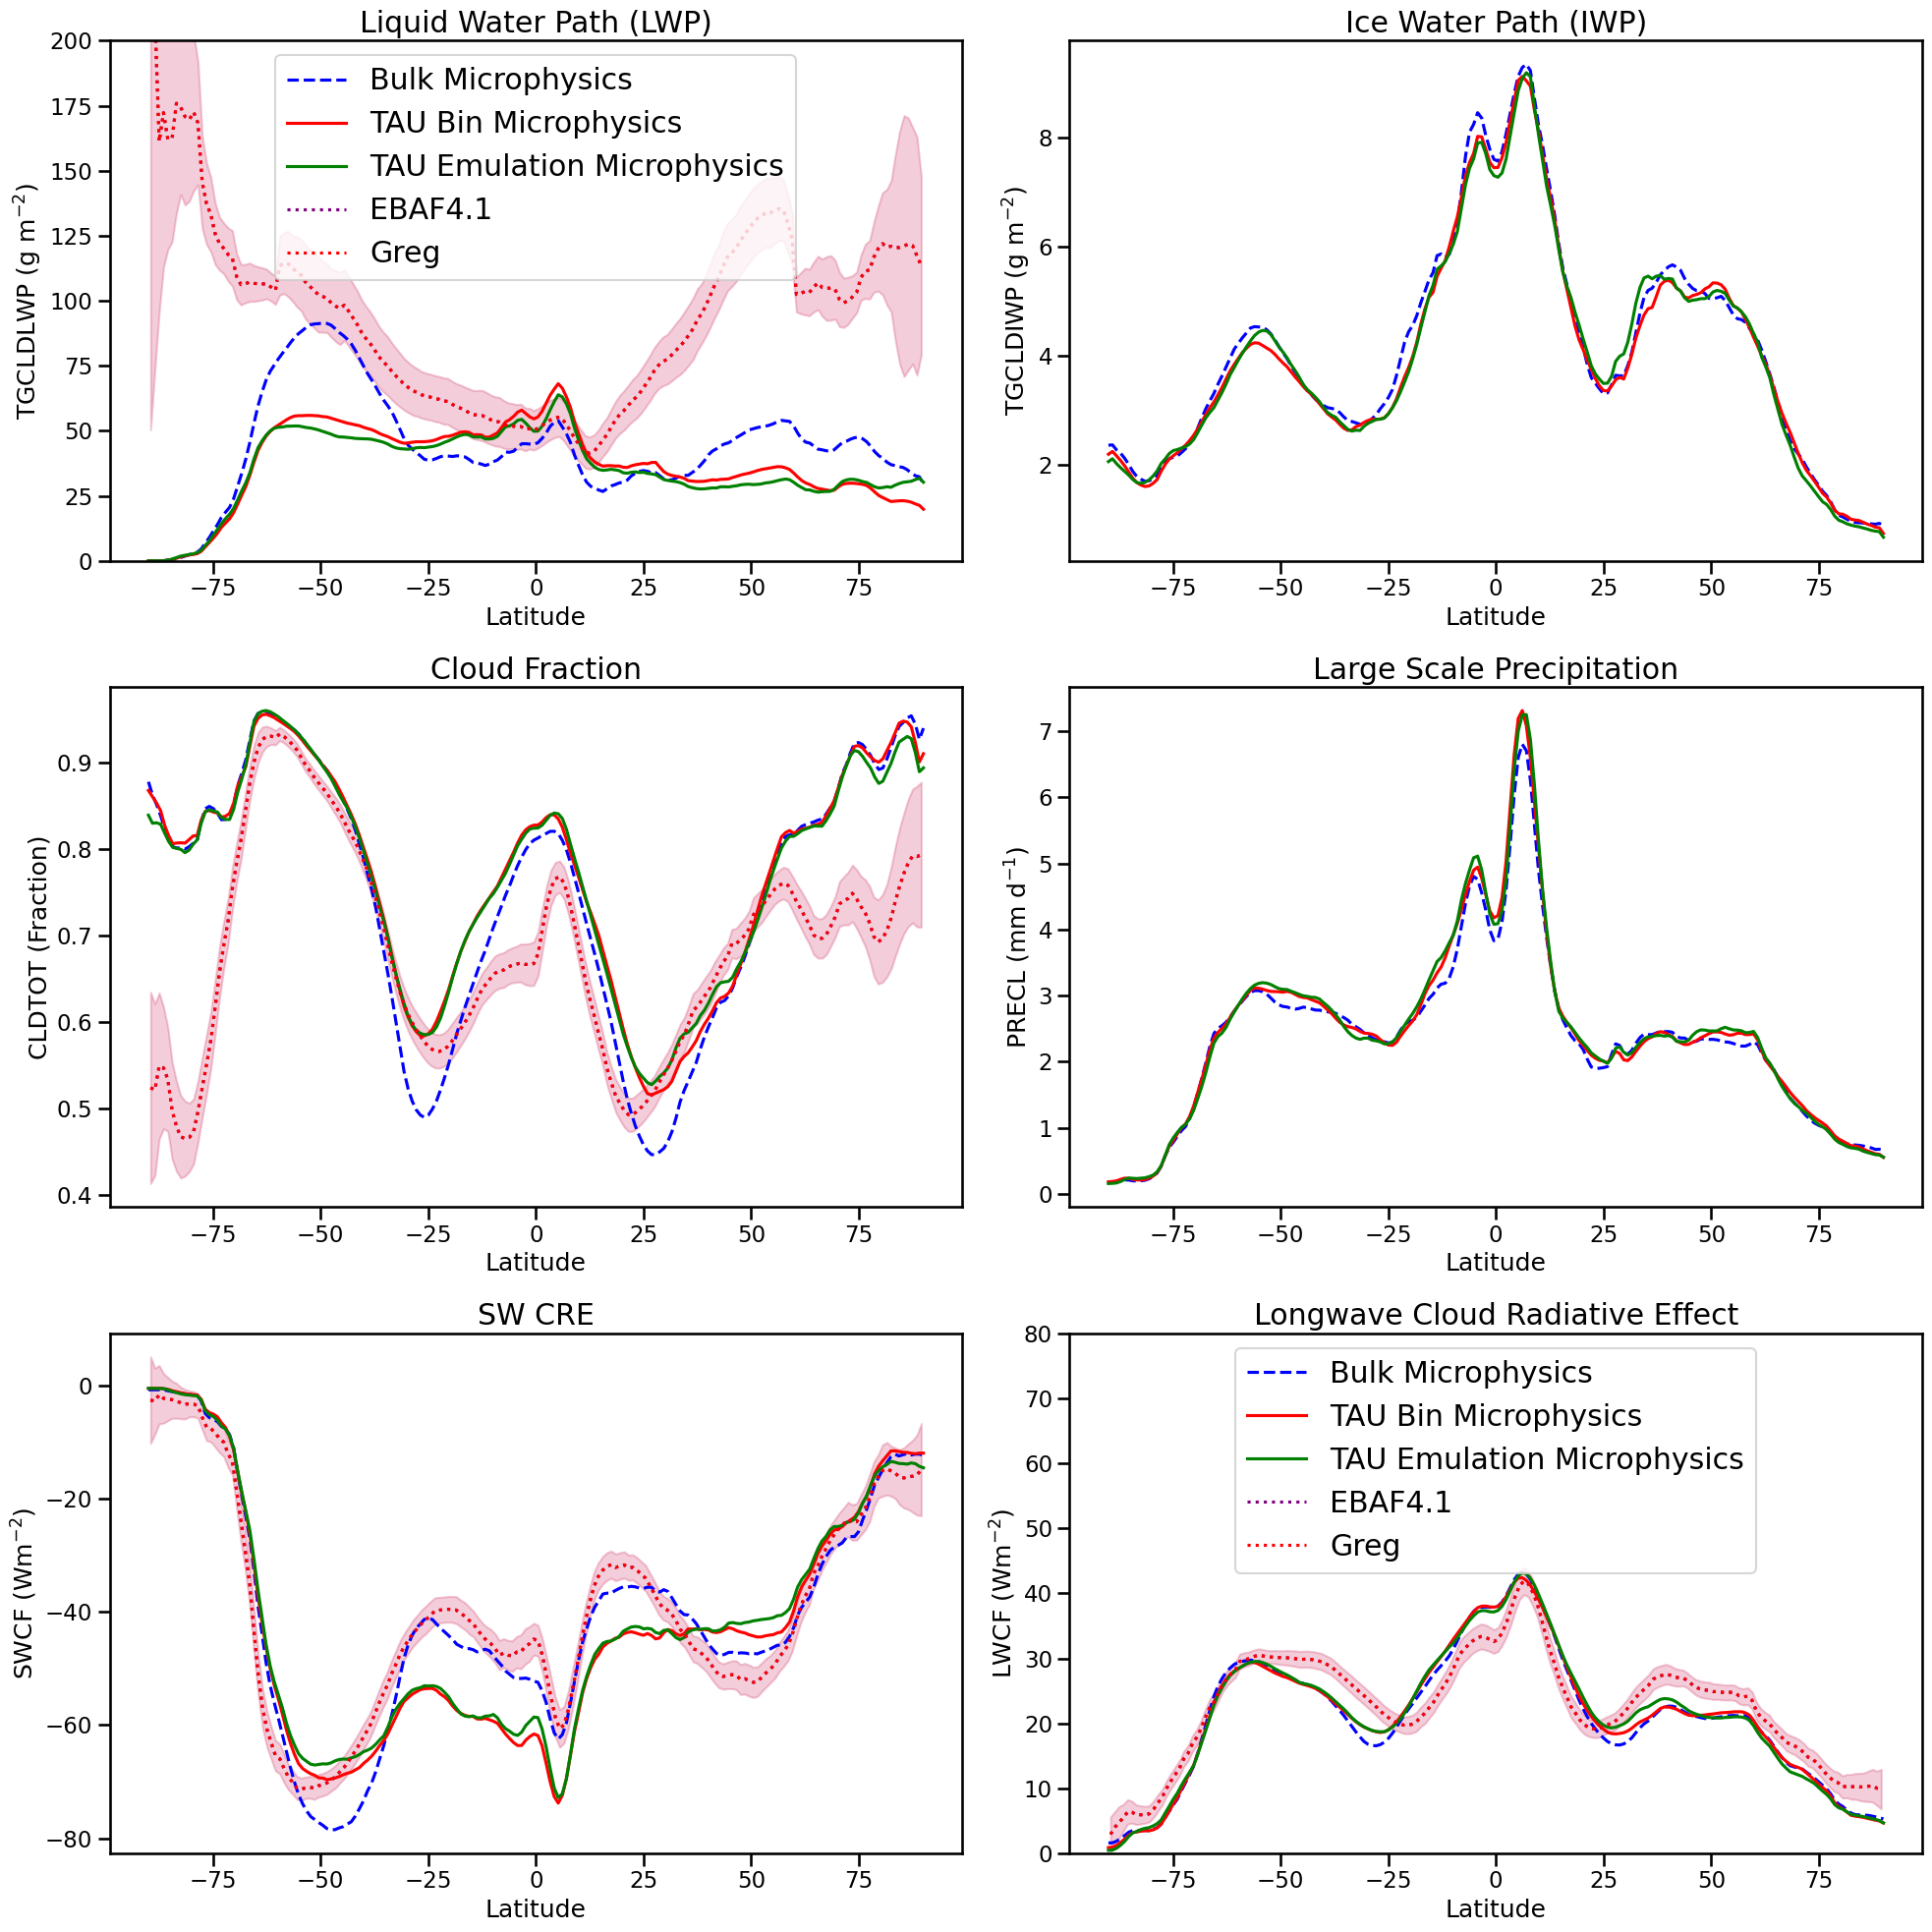

In [25]:
savfig=False

#Fancier plots
plt.rcParams['figure.figsize'] = [15, 20]

linestyles = ['--','-','-','--','--', '-', '-','-', ':','-']

hfont = {'fontname':'Helvetica'}

lbl=['A','B','C','D','E','F','G','H','I','J']
cls=['blue','red','green','orange','teal','coral','indigo','brown','gray']

#fig,axs=plt.subplots(var_name_len)

fig,axs=plt.subplots(3,2,figsize=(20, 20))

axs = axs.ravel()

for v in range(6):

    sns.set_context("talk")
    
    for r in range(case_len):
        axs[v].plot(azm.lat,azm.sel(runs=casetext[r],variables=varnout[v])*vscl[v],linestyles[r], label=casetext[r],color=cls[r])

    if (var_names[v] == 'SWCF' or var_names[v] == 'LWCF' or var_names[v] == 'CLDTOT' or var_names[v] == 'FSUTOA' 
        or var_names[v]=='TGCLDLWP' or var_names[v]=='TOT_CLD_VISTAU'):
        if var_names[v] == 'SWCF':
            tmp=cswcfzm.values
            std=cswcfstd.values
        if var_names[v] == 'LWCF':
            tmp=clwcfzm.values
            std=clwcfstd.values
            axs[v].set_ylim([0, 80])
        if var_names[v] == 'CLDTOT':
            tmp=cctotzm.values/100.
            std=cctotstd.values/100.
        if var_names[v] =='FSUTOA':
            tmp=cfsntzm
        if var_names[v] =='FSNTC':
            tmp=cfsntczm
        if var_names[v] =='TOT_CLD_VISTAU':
            tmp=cctauzm
            std=cctaustd.values
        if var_names[v] =='TGCLDLWP':
            tmp=cclwpzm*1000.
            std=cclwpstd.values*1000.
            axs[v].set_ylim([0,200.])
#        if var_names[v] =='TGCLDIWP':
#            tmp=cciwpzm*1000.
#            std=cciwpstd.values*1000.
        axs[v].plot(cswcfzm.lat,tmp,linestyles[0], label='EBAF4.1',color='purple',linestyle=':')
        axs[v].fill_between(cswcfzm.lat,tmp+std,tmp-std,alpha=0.1,color='purple')
# Add Greg's data to the chart
        axs[v].plot(clwp_zonal_mean.lat,tmp,linestyles[0], label='Greg',color='red',linestyle=':')
        axs[v].fill_between(cswcfzm.lat,tmp+std,tmp-std,alpha=0.1,color='red')
#    axs[v].set_title(lbl[v]+') '+vartx[v],fontsize=16,**hfont)
    axs[v].set_title(vartx[v], fontsize='large')
#    if var_names[v] =='TGCLDLWP' or var_names[v] =='TGCLDIWP':
    if var_names[v] =='TGCLDLWP':
        axs[v].legend(loc='upper center',fontsize='large')
    if var_names[v] =='LWCF':
        axs[v].legend(loc='upper center',fontsize='large')
#    else:
#        axs[v].legend(loc='lower right',fontsize='small')            
    axs[v].set_xlabel('Latitude')
    axs[v].set_ylabel(var_names[v]+' ('+var_units[v]+')')

    
fig.tight_layout()
#plt.show()
if savfig:
    plt.savefig(pwd+'zm_ml_revised_tau_3nn_lev_1nn_comparison_renewal.png')